In [55]:
from spinbox import *
from spinbox.extras import chistogram
from itertools import count
global_seed = 0
seeder = count(global_seed,1) # generates a list of counting numbers for rng "seeds" (not really seeds in Numpy, but indices of seeds)

def npr(name, thing):
    print(name,"\n",thing,"\n"+16*"-")

# Tutorial 4: Realistic imaginary-time propagation in the full basis space


Our potentials have the form
$$
    V = \sum_{ij} \sum_{p} v_p(r_{ij})O^{(p)}_{ij}
$$

where $i,j$ label particles, $r_{ij}=|r_i-r_j|$, and $O^{(p)}$ are the operators. These operators generally fall into one of three categories: charge-independent (CI), charge-dependent (CD), and charge-symmetry-breaking (CSB).

$$
    O^{\text{CI}}_{ij} = \left[ 1, \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j, S_{ij}, \mathbf{L}_{ij} \cdot \mathbf{S}_{ij}, \mathbf{L}^2, \mathbf{L}^2(\mathbf{\sigma}_i \cdot \mathbf{\sigma}_j), (\mathbf{L}_{ij} \cdot \mathbf{S}_{ij})^2 \right] \otimes  \left[ 1, \mathbf{\tau}_i \cdot \mathbf{\tau}_j \right] 
$$

The spin tensor operator is defined $S_{ij} = 3(\mathbf{\sigma}_i \cdot \mathbf{r}_{ij})(\mathbf{\sigma}_j \cdot \mathbf{r}_{ij}) - \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j$. The total spin operator is $\mathbf{S}_{ij} = \frac{1}{2}(\mathbf{\sigma}_i+\mathbf{\sigma}_j)$, and the (relative) angular momentum operator is ~$\mathbf{L}_{ij} = \frac{1}{2i}(\mathbf{r}_i-\mathbf{r}_j) \times (\mathbf{\nabla}_i-\mathbf{\nabla}_j)$.

$$
    O^{\text{CD}}_{ij} = \left[ 1, \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j, S_{ij} \right] \otimes T_{ij}
$$

The isospin tensor operator is $T_{ij} = 3\tau_{iz}\tau_{jz} - \mathbf{\tau}_i\cdot\mathbf{\tau}_j$.
The CSB part has only one term, the Coulomb: $O^\text{CSB}_{ij} = \frac{1}{2}(\tau_{zi} + \tau_{zj})$.

Keep in mind that often when we code these up the coefficient structure will be simplified. So, for instance, if you have combine the spin and spin-tensor parts, you could write

$$
    v_\sigma \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j + v_S \left[ 3(\mathbf{\sigma}_i \cdot \mathbf{r}_{ij})(\mathbf{\sigma}_j \cdot \mathbf{r}_{ij}) - \mathbf{\sigma}_i \cdot \mathbf{\sigma}_j \right]
    = \sum_{i \alpha j \beta} A_{i \alpha j \beta} \sigma_{i \alpha} \sigma_{j \beta}
$$

where $A_{i \alpha j \beta}$ is just an array of coefficients that depends on the corresponding local potentials and coordinates, etc. Because of this, we will skip to writing the potential in this form:

$$
    \hat{V} = \sum_{i \alpha j \beta} A^{\sigma}_{i \alpha j \beta} \hat{\sigma}_{i \alpha} \hat{\sigma}_{j \beta} + \sum_{i \alpha j \beta \gamma} A^{\sigma\tau}_{i \alpha j \beta} \hat{\sigma}_{i \alpha} \hat{\sigma}_{j \beta} \hat{\tau}_{i \gamma} \hat{\tau}_{j \gamma} + \sum_{i j \gamma} A^\tau_{i j} \hat{\tau}_{i \gamma} \hat{\tau}_{j \gamma} + \cdots
$$


In [56]:
n_particles = 2

# s = HilbertState(n_particles).random(next(seeder))
# sp = HilbertState(n_particles, ketwise=False).random(next(seeder))

# to compare with the product state version of this code, we instantiate the states as product states and then project them to the full basis
s = ProductState(n_particles).random(next(seeder)).to_full_basis()
sp = ProductState(n_particles, ketwise=False).random(next(seeder)).to_full_basis()

At the time of writing, `spinbox` has built-in support for two-body $\sigma, \sigma\tau, \tau, L \cdot S$, Coulomb forces, and three-body $\sigma\tau$. For this tutorial we will just look at the two-body $\sigma$ term, but consider the product of propagators over pairs of particles and dimensions.

$$ \exp \left( {- \frac{\delta\tau}{2} \sum_{i \alpha j \beta} A^\sigma_{i \alpha j \beta} \hat{\sigma}_{i \alpha} \hat{\sigma}_{j \beta} } \right) \approx \prod_{i \alpha j \beta} \exp \left( {- \frac{\delta\tau}{2} A^\sigma_{i \alpha j \beta} \hat{\sigma}_{i \alpha} \hat{\sigma}_{j \beta} } \right) $$

First, we need the coupling matrix $ A^\sigma_{i \alpha j \beta} $. One can load this from file or generate it randomly. Here is one way to do the latter.

In [57]:
coupling_array = TwoBodyCoupling(n_particles,).random(mean=-2.0, scale=2.0, seed=1)
print(coupling_array.shape, "\n",  coupling_array)

(3, 2, 3, 2) 
 [[[[ 0.         -3.07390647]
   [ 0.         -1.27085521]
   [ 0.         -1.94315552]]

  [[-3.07390647  0.        ]
   [-1.27085521  0.        ]
   [-1.94315552  0.        ]]]


 [[[ 0.         -3.56381692]
   [ 0.         -1.98371564]
   [ 0.          0.58812763]]

  [[-3.56381692  0.        ]
   [-1.98371564  0.        ]
   [ 0.58812763  0.        ]]]


 [[[ 0.          2.23567751]
   [ 0.         -2.75521001]
   [ 0.         -0.70659401]]

  [[ 2.23567751  0.        ]
   [-2.75521001  0.        ]
   [-0.70659401  0.        ]]]]


However, we have a container class for nuclear potentials, which has all the supported couplings built in. In the long run, this can be more convenient. The following is equivalent to making the `TwoBodyCoupling` by itself. Also, note that the `.random()` method obeys expected symmetries.

**WARNING**: the order of indices follows the convention of NUAFDMC, which puts dimensions *before* particle indices. This is different from how I write my notes. 

In [58]:
pot = NuclearPotential(n_particles)
pot.sigma.random(mean=-2.0, scale=2.0, seed=1)  # this does the same as above
print(pot.sigma)

[[[[ 0.         -3.07390647]
   [ 0.         -1.27085521]
   [ 0.         -1.94315552]]

  [[-3.07390647  0.        ]
   [-1.27085521  0.        ]
   [-1.94315552  0.        ]]]


 [[[ 0.         -3.56381692]
   [ 0.         -1.98371564]
   [ 0.          0.58812763]]

  [[-3.56381692  0.        ]
   [-1.98371564  0.        ]
   [ 0.58812763  0.        ]]]


 [[[ 0.          2.23567751]
   [ 0.         -2.75521001]
   [ 0.         -0.70659401]]

  [[ 2.23567751  0.        ]
   [-2.75521001  0.        ]
   [-0.70659401  0.        ]]]]


Next, we create some `Propagator` objects: a `ExactPropagator`, which is what it sounds like, and a `HilbertPropagatorHS`, which does the Hubbard-Stratonovich transform in the full basis, and a `HilbertPropagatorRBM`, which does the RBM transform in the full basis.

In [59]:
dt = 0.01
prop_exact = ExactPropagator(n_particles, dt)
prop_hs = HilbertPropagatorHS(n_particles, dt)
prop_rbm = HilbertPropagatorRBM(n_particles, dt)

First, use the `ExactPropagator` to compute the amplitude. The method `.propagator_combined` takes a `NuclearPotential` and computes the full propagator as a `HilbertOperator`, given the forces as boolean arguments (e.g., `sigma=True`).

In [60]:
amp_exact = sp * prop_exact.propagator_combined(pot, sigma=True) * s
npr("exact amplitude: ", amp_exact)

exact amplitude:  
 [[-0.24448444+0.14548456j]] 
----------------


Next, we will do the HS transformation. This requires summing up many brackets, each with a random sample of the auxiliary field. Enter, the `Integrator` class. 

In [61]:
n_samples = 100000  # use this number of samples for all calculations in this notebook
integ = Integrator(potential=pot, propagator=prop_hs)
integ.setup(n_samples, seed=next(seeder), sigma=True)
amp_samples_hs = integ.run(sp, s)

100%|██████████| 100000/100000 [00:08<00:00, 11641.39it/s]


This has calculated `n_sample` random samples from the distribution of the HS "kernel" (i.e. summand).

HS amplitude = (-0.2449444547523388+0.14570976782918646j) +/- 0.00027986534293051126


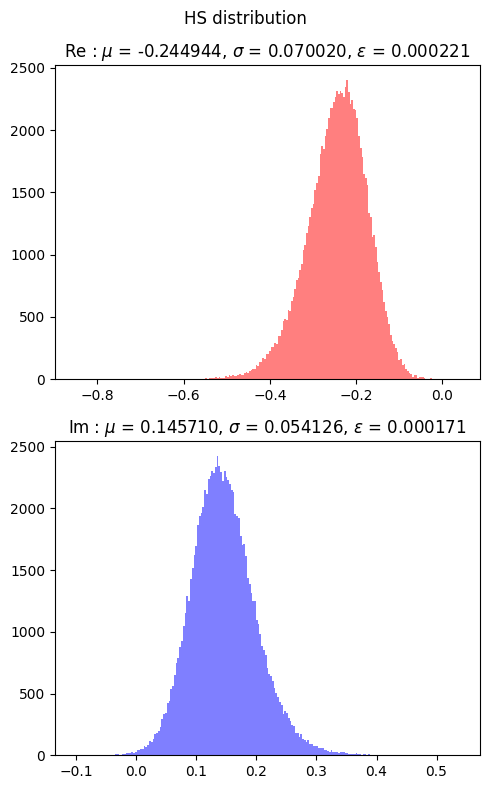

In [62]:
amp_mean_hs = np.mean(amp_samples_hs)
amp_std_hs = np.std(amp_samples_hs)
print(f"HS amplitude = {amp_mean_hs} +/- {amp_std_hs/np.sqrt(n_samples)}")
chistogram(amp_samples_hs, filename=None, title="HS distribution")

Finally, we do the same using the RBM.

In [63]:
integ = Integrator(potential=pot, propagator=prop_rbm)
integ.setup(n_samples, seed=next(seeder), sigma=True)
amp_samples_rbm = integ.run(sp, s)

100%|██████████| 100000/100000 [00:13<00:00, 7666.85it/s]


RBM amplitude = (-0.24424485738414287+0.14558918138947005j) +/- 0.0002573359424028927


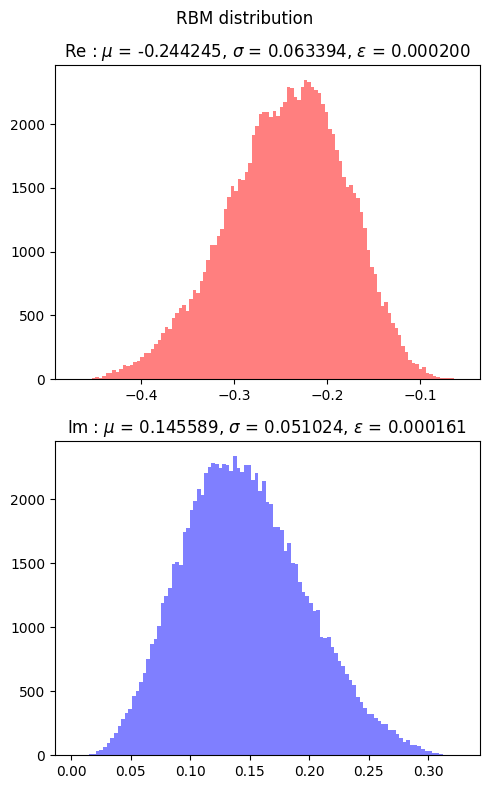

In [64]:
amp_mean_rbm = np.mean(amp_samples_rbm)
amp_std_rbm = np.std(amp_samples_rbm)
print(f"RBM amplitude = {amp_mean_rbm} +/- {amp_std_rbm/np.sqrt(n_samples)}")
chistogram(amp_samples_rbm, filename=None, title="RBM distribution")

Let's take a look at the errors.

In [65]:
npr("HS error = ", (amp_mean_hs - amp_exact)/ amp_exact)
npr("RBM error = ", (amp_mean_rbm - amp_exact)/ amp_exact)

HS error =  
 [[0.00179433+0.0001466j]] 
----------------
RBM error =  
 [[-0.00053564-0.00074666j]] 
----------------


We can reduce the error by "balancing" the calculation over the auxiliary field, like so.

In [66]:
# hs
integ = Integrator(potential=pot, propagator=prop_hs)
amp_samples_hs = np.zeros(2*n_samples, dtype=complex)

integ.setup(n_samples, seed=next(seeder), sigma=True)
amp_samples_hs[:n_samples] = integ.run(sp, s)

integ.setup(n_samples, seed=next(seeder), sigma=True, flip_aux=True)
amp_samples_hs[n_samples:] = integ.run(sp, s)

# rbm
integ = Integrator(potential=pot, propagator=prop_rbm)
amp_samples_rbm = np.zeros(2*n_samples, dtype=complex)

integ.setup(n_samples, seed=next(seeder), sigma=True)
amp_samples_rbm[:n_samples] = integ.run(sp, s)

integ.setup(n_samples, seed=next(seeder), sigma=True, flip_aux=True)
amp_samples_rbm[n_samples:] = integ.run(sp, s)


100%|██████████| 100000/100000 [00:13<00:00, 7226.46it/s]


HS amplitude, balanced = (-0.24433876492256865+0.14558118102281017j) +/- 0.0001968073463188495


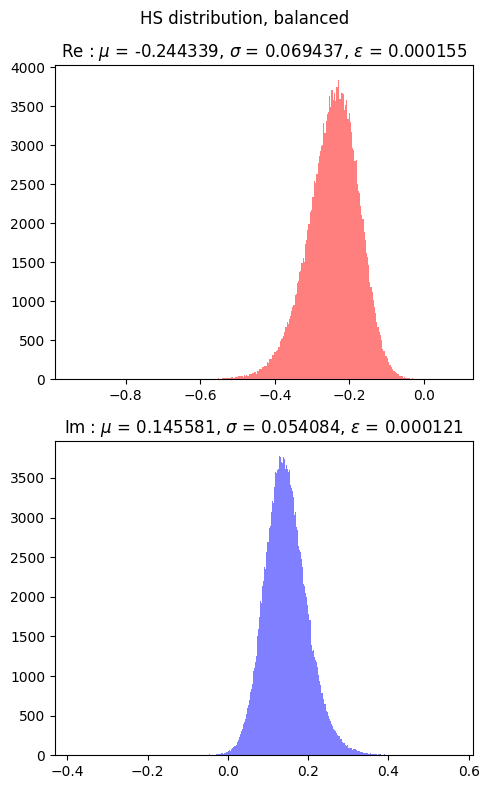

In [67]:
amp_mean_hs = np.mean(amp_samples_hs)
amp_std_hs = np.std(amp_samples_hs)
print(f"HS amplitude, balanced = {amp_mean_hs} +/- {amp_std_hs/np.sqrt(2*n_samples)}")
chistogram(amp_samples_hs, filename=None, title="HS distribution, balanced")

RBM amplitude, balanced = (-0.24457684956194956+0.14564814435846382j) +/- 0.0001819175236116011


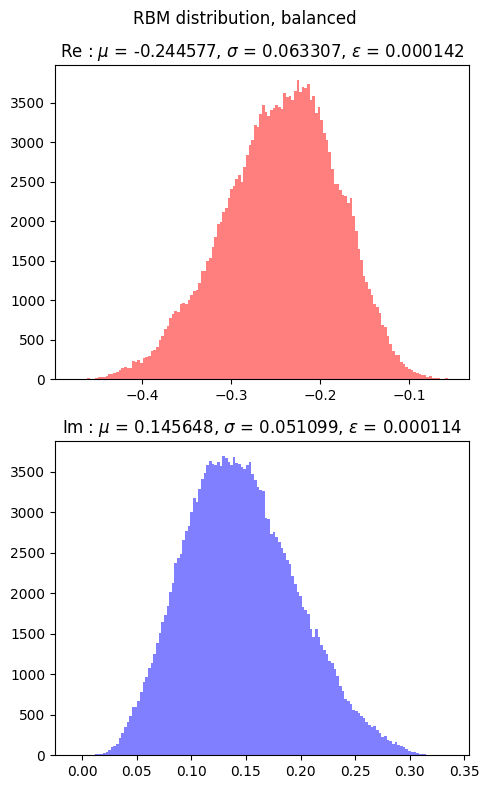

In [68]:
amp_mean_rbm = np.mean(amp_samples_rbm)
amp_std_rbm = np.std(amp_samples_rbm)
print(f"RBM amplitude, balanced = {amp_mean_rbm} +/- {amp_std_rbm/np.sqrt(2*n_samples)}")
chistogram(amp_samples_rbm, filename=None, title="RBM distribution, balanced")

In [69]:
npr("HS error = ", (amp_mean_hs - amp_exact)/ amp_exact)
npr("RBM error = ", (amp_mean_rbm - amp_exact)/ amp_exact)

HS error =  
 [[-0.00026636-0.0005537j]] 
----------------
RBM error =  
 [[0.00057316-0.00032802j]] 
----------------


The balancing trick gives significantly smaller errors. 